<a href="https://colab.research.google.com/github/jovitaand/Mitigating-computational-bias-using-Fairlearn/blob/main/Mitigating_computational_bias_using_Fairlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mitigating computational bias using Fairlearn


Fairness in AI is a multidisciplinary field focused on understanding and reducing the potential negative impacts of AI on society. In this tutorial, we’ll evaluate and address fairness-related issues within the context of the U.S. healthcare system. Using the Python library Fairlearn, we’ll examine machine learning models for performance differences across sensitive groups and explore different algorithmic techniques to help reduce these disparities.

## Install packages

In [1]:
!pip install Fairlearn
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 3.6 MB/s eta 0:00:00


## Import and set up packages

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn import set_config

set_config(display="diagram")

In [5]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [6]:
from IPython import display
from datetime import date

# **Introduction of Fairlearn and other tutorial resources**


### [Fairlearn](https://fairlearn.org)

Fairlearn is an open-source, community-driven project to help data scientists improve fairness of AI systems. It includes:

* A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)

* Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

The project was started in 2018 at Microsoft Research. In 2021 it adopted a neutral governance structure and since then it is completely community-driven.

# **Introduction to the health care scenario**

The following scenario builds on previous research that highlights racial disparities in how health care resources are allocated in the U.S. ([Obermeyer et al., 2019](https://science.sciencemag.org/content/366/6464/447.full)).
Motivated by that work, in this tutorial we consider an automated system for recommending patients for _high-risk care management_ programs, which are described by Obermeyer et al. 2019 as follows:

> These programs seek to improve the care of patients with complex health needs by providing additional resources, including greater attention from trained providers, to help ensure that care is well coordinated. Most health systems use these programs as the cornerstone of population health management efforts, and they are widely considered effective at improving outcomes and satisfaction while reducing costs. [...] Because the programs are themselves expensive—with costs going toward teams of dedicated nurses, extra primary care appointment slots, and other scarce resources—**health systems rely extensively on algorithms to identify patients who will benefit the most.**

**Convenience restriction**

* In practice, the modeling of health needs would use large data sets covering a wide range of diagnoses. In this tutorial, we will work with a [publicly available clinical dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that focuses on _ diabetes patients only_ ([Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)).

## Dataset and task

We’ll be working with a clinical dataset that tracks hospital readmissions for diabetes patients over a ten-year period (1998-2008) from 130 hospitals in the U.S. Each record reflects details of a hospital stay for a patient with diabetes, lasting between one and fourteen days.

This dataset includes information on patient demographics, diagnoses, diabetes medications, number of prior hospital visits, payer details, and whether a patient was readmitted within 30 days after release.

Our goal is to build a classification model that predicts whether patients should be referred to their primary care physicians for a high-risk care management program. A positive prediction would mean a recommendation for enrollment in this program.

## Decision Point: Task Definition

We’ll use readmission within 30 days as a **proxy** for identifying patients who might need more support after discharge. This will serve as our prediction target.

Due to the class imbalance, we’ll use balanced accuracy to measure model performance. Another key metric will be selection rate, indicating the proportion of patients recommended for care.

In an ideal scenario, healthcare professionals would help design and validate the model to ensure the task definition aligns closely with patient care needs.


## Fairness considerations

To evaluate and address potential harms, especially those that may impact specific groups disproportionately, here are some key considerations:

* Which groups are most likely to be disproportionately negatively affected?
Prior studies indicate that disparities can exist across racial and ethnic groups. Therefore, we should pay special attention to how the model performs across these groups to ensure fair access to resources and support.

* What are the harms?
The primary concern here is allocation harm. Specifically, false negatives pose a risk, as they mean that patients who are likely to be readmitted are not recommended for the high-risk care management program. This could result in those needing support not receiving it, potentially affecting their health outcomes.

* How should we measure these harms?
We can quantify these harms by monitoring false negative rates for each group, comparing disparities between them. Additionally, using metrics like equalized odds (which ensures similar error rates across groups) and demographic parity (which ensures a similar selection rate across groups) can provide a clearer picture of whether allocation harms are occurring, and if so, to what extent.


In the remainder of the tutorial we will:
* Examine the dataset and our choice of label with an eye towards a variety of fairness issues.
* Then, train a logistic regression model and assess its performance as well as fairness.
* Finally, look at two unfairness mitigation strategies.

# Task definition and dataset characteristics


In this section, we’ll start by loading the dataset and examining it for potential fairness issues. Key areas to focus on include:

* Sample Sizes Across Demographic Groups:
We'll first check the sample sizes of various demographic groups, paying particular attention to different racial groups. This helps ensure that all groups are adequately represented, as imbalances could impact model performance and fairness.

* Choice of Label Appropriateness:
Next, we’ll consider whether our chosen label—readmission within 30 days—is appropriate for our task. It's essential that the label accurately reflects the outcome we aim to predict to ensure our model's effectiveness and fairness.

In addition to dataset characteristics, it’s important to consider how the data was collected. Ensuring that data collection respects the autonomy of individuals is a key aspect of ethical AI practices, as it aligns with transparency and fairness principles.

To help us document and communicate our understanding of the dataset, we’ll use the datasheets method. By systematically documenting dataset characteristics and any potential concerns, we can anticipate and highlight issues that may arise during model training, evaluation, and deployment.



## Load the dataset


We can now load the dataset and review the meaning of its columns.


In [7]:
df = pd.read_csv("https://respai.s3.us-east-2.amazonaws.com/fairlern_data_preprocessed.csv")

In [8]:
df.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0


The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |




In [9]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,Norm,>200,>300,,,
A1Cresult,>8,Norm,>7,,,
insulin,No,Steady,Down,Up,,


We mark all categorical features:

In [10]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [11]:
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

## Group sample sizes

In fairness assessment, an essential characteristic to consider is the sample size of the demographic groups we’re assessing. Smaller sample sizes can impact both the assessment and model training stages:

* Assessment: With smaller groups, it becomes harder to assess the impact of the AI system because the limited data points increase uncertainty (or error) in our estimates. This larger margin of error can make it difficult to draw reliable conclusions about fairness impacts on these groups.

* Model Training:
Smaller sample sizes also mean fewer data points available during model training, making it challenging for the model to capture specific patterns for these groups. As a result, the model’s predictive performance may be worse for these groups, potentially leading to biased outcomes.

Let’s start by examining the sample sizes for the groups in our dataset according to the race variable. This will give us insight into how well each group is represented, which is crucial for understanding any fairness concerns.



In [12]:
df["race"].value_counts()

,count
race,
Caucasian,76099
AfricanAmerican,19210
Unknown,2273
Hispanic,2037
Other,1506
Asian,641


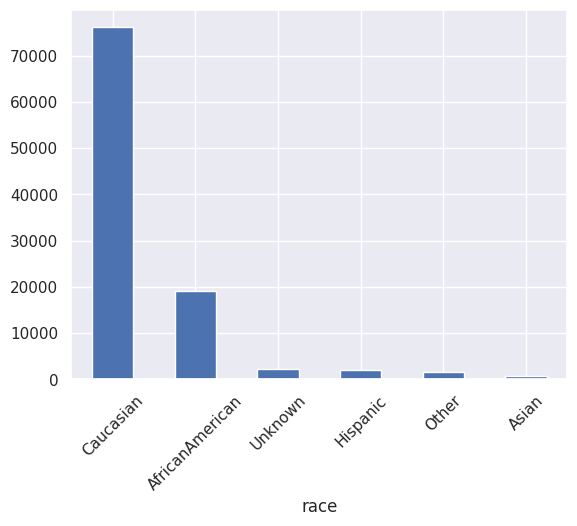

In [13]:
df["race"].value_counts().plot(kind='bar', rot=45);

Normalized as frequencies:

In [14]:
df["race"].value_counts(normalize=True)

,proportion
race,
Caucasian,0.748
AfricanAmerican,0.189
Unknown,0.022
Hispanic,0.020
Other,0.015
Asian,0.006


In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.

##YOUR TASK: Examine the dataset composition by `gender`:

In [15]:
 # counts
 df["gender"].value_counts()

,count
gender,
Female,54708
Male,47055
Unknown/Invalid,3


In [16]:
 # frequencies
df["gender"].value_counts(normalize = True)

,proportion
gender,
Female,0.538
Male,0.462
Unknown/Invalid,0.000


## YOUR TASK: Write a brief comment to describe the distribution of the data by gender

The dataset shows a gender distribution where female patients represent 53.8% and male patients represent 46.2% of the total. There is no presence of the 'Unknown/Invalid' gender category in the final dataset after removing records with missing gender information

### Decision point: How do we address smaller group sizes?

When certain groups are underrepresented in the dataset, it limits our ability to effectively assess fairness. Here are three possible interventions we can consider (and even combine) to address this:

* Collect More Data:
Gather additional data for underrepresented groups. This is the most reliable approach for improving assessment and performance but may not always be feasible.

* Bucketing Groups:
Combine smaller groups with similar characteristics to increase sample size. While this approach can improve the reliability of assessments, we need to ensure that the combined groups share similar risks. Otherwise, merging could mask potential harms.

* Dropping Small Groups:
Remove groups with very few samples if they are too small to support meaningful analysis. However, dropping groups can lead to representational harm by erasing them from the analysis. Therefore, we recommend this approach only when absolutely necessary.

In all cases, decisions to merge or drop groups should be clearly documented in the datasheet to ensure transparency and traceability.

For our dataset, we’ll use the following strategies:

* Merging Groups:
We’ll merge the three smallest racial groups (Asian, Hispanic, and Other) to create a combined category. However, we’ll retain the original group labels for auxiliary assessments, in case we need them for more nuanced analysis.

* Dropping Gender Group:
The gender group labeled Unknown/Invalid has such a small sample size that assessing fairness meaningfully isn’t feasible. We’ll remove this group but document the decision in our datasheet to avoid representational harm wherever possible.

In [17]:
# retain the original race as race_all, and merge Asian+Hispanic+Other
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

# drop gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")

<ipython-input-17-6ab4e55bd3f4>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})


## Examining the choice of label

Next we dive into the question of whether our choice of label (readmission within 30 days) aligns with our goal (identify patients that would benefit from the care management program).

A framework particularly suited for this analysis is called _measurement modeling_ (see, e.g., [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511)). The goal of measurement modeling is to describe the relationship between what we care about and what we can measure. The thing that we care about is referred to as the _construct_ and what we can observe is referred to as the _measurement_. In our case:
* **construct** = greatest benefit from the care management program
* **measurement** = readmission within 30 days (in the absence of such program)

In our case, the **measurement** coincides with the **classification label**.

The act of _operationalizing_ the construct via a specific measurement corresponds to making certain assumptions. In our case, we are making the following assumption: **the greatest benefit from the care management program would go to patients that are** (in the absence of such a program) **most likely to be readmitted into the hospital within 30 days.**

### How can we check whether our assumptions apply?

In the terminology of measurement modeling, how do we establish _construct validity_? Following, [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511),

> Establishing construct
validity means demonstrating, in a variety of ways, that the measurements obtained from measurement model are both meaningful
and useful:
> * Does the operationalization capture all relevant aspects
of the construct purported to be measured?
> * Do the measurements
look plausible?
> * Do they correlate with other measurements of the
same construct? Or do they vary in ways that suggest that the
operationalization may be inadvertently capturing aspects of other
constructs?
> * Are the measurements predictive of measurements of
any relevant observable properties (and other unobservable theoretical constructs) thought to be related to the construct, but not incorporated into the operationalization?

We focus on one aspect of construct validity, called _predictive validity_, which refers to the extent
to which the measurements obtained from a measurement model
are predictive of measurements of any relevant observable properties
related to the construct purported to be measured, but not incorporated into the operationalization.

### Predictive validity

We need to show that our measurement `readmit_30_days` is correlated with patient characteristics that are related to our construct "benefiting from care management". One such characteristic is the general patient health, where we expect that patients that are less healthy are more likely to benefit from care management.

While our data does not contain full health records that would enable us to holistically measure general patient health, the data does contain two relevant features: `had_emergency` and `had_inpatient_days`, which indicate whether the patient spent any days in the emergency room or in the hospital (but non-emergency) in the preceding year.

To establish predictive validity, we would like to show that our measurement `readmit_30_days` is predictive of these two observable characteristics.

First, let's check the rate at which the patients with different `readmit_30_days` labels were readmitted in the previous year:

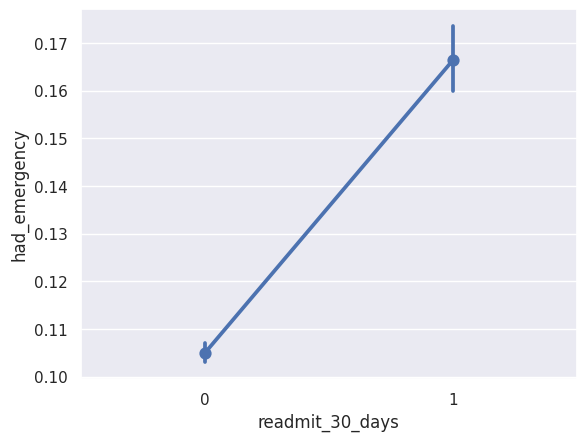

In [18]:
sns.pointplot(y="had_emergency", x="readmit_30_days",
              data=df, errorbar=('ci', 95));

The plot shows that patients with `readmit_30_days=0` have a lower rate of emergency visits in the prior year, whereas patients with `readmit_30_days=1` have a larger rate. (The vertical lines indicate 95% confidence intervals obtained via boostrapping.)

We see a similar pattern when `readmit_30_days` is used to predict the rate of (non-emergency) hospital visits in the previous year:

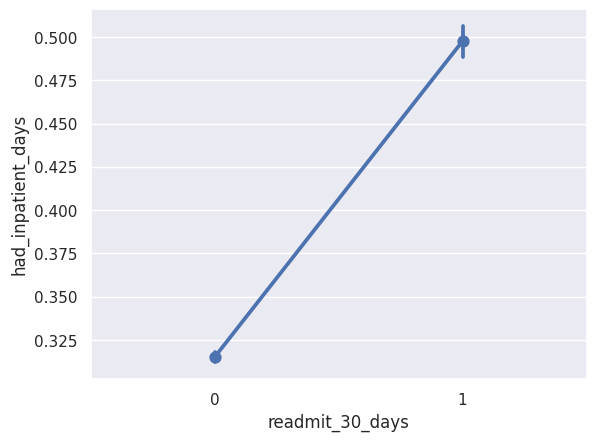

In [19]:
sns.pointplot(y="had_inpatient_days", x="readmit_30_days",
              data=df, errorbar=('ci', 95));

Now let's take a look whether the predictiveness is similar across different race groups. First, let's check how well `readmit_30_days` predicts `had_emergency`:

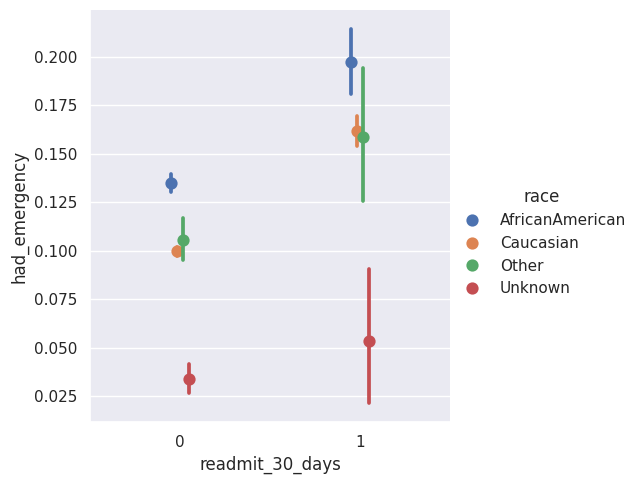

In [20]:
# Visualize predictiveness using a categorical pointplot
sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,
            kind="point", dodge=True, errorbar=('ci', 95), linestyle='none');

The patients in the group *Unknown* have a substantially lower rate of emergency visits in the prior year, regardless of whether they are readmitted in 30 days. The readmission is still positively correlated with `had_emergency`, but note the large error bars (due to small sample sizes).

We also see that the group with feature value *AfricanAmerican* has a higher rate of emergency visits compared with other groups. However, generally the groups *Caucasian*, *AfricanAmerican* and *Other* follow similar dependence patterns.

## YOUR TASK: Visualize the predictive validity for `readmit_30_days` in predicting the rate of (non-emergency) hospital visits in the previous year:

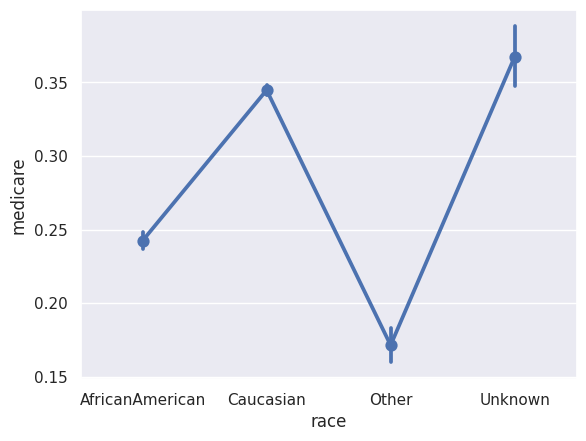

In [21]:
#Hint: Use the had_inpatient_days variable
sns.pointplot(y="medicare", x="race", data=df);

Again, for *Unknown* the rate of (non-emergency) hospital visits in the previous year is lower than for other groups.In all groups there is a strong positive correlation between `readmit_30_days` and `had_inpatient_days`.

In all cases, we see that readmission in 30 days is predictive of our two measurements of general patient health.

The analysis is also surfacing the fact that patients with the value of race *Unknown* have fewer hospital visits in the preceding year (both emergency and non-emergency) than other groups. In practice, this would be a good reason to reach out to health professionals to investigate this patient cohort, to make sure that we understand why there is the systematic difference.

## Label imbalance



Now that we have established the validity of our label, we will check frequency of its values in our data. The frequency of different labels is an important descriptive characteristic in classification settings for several reasons:

* some classification algorithms and performance measures might not work well with data sets with extreme class imbalance
* in binary classification settings, our ability to evaluate error is often driven by the size of the smaller of the two classes (again, the smaller the sample the larger the uncertainty in estimates)
* label imbalance may exacerbate the problems due to smaller group sizes in fairness assessment



Let's check how many samples in our data are labeled as positive and how many as negative.

In [22]:
df["readmit_30_days"].value_counts() # counts

,count
readmit_30_days,
0,90406
1,11357


In [23]:
df["readmit_30_days"].value_counts(normalize=True) # frequencies

,proportion
readmit_30_days,
0,0.888
1,0.112


As we can see, the target label is heavily skewed towards the patients not being readmitted within 30 days. In our dataset, only 11% of patients were readmitted within 30 days.

Since there are fewer positive examples, we expect that we will have a much larger uncertainty (error bars) in our estimates of *false negative rates* (FNR), compared with *false positive rates* (FPR). This means that there will be larger differences between training FNR and test FNR, even if there is no overfitting, simply because of the smaller sample sizes.

Our target metric is *balanced error rate*, which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives. However, since half of the metric is contributed by FNR, we expect the uncertainty in balanced error values to behave similarly to the uncertainty of FNR.

Now, let's examine how much the label frequencies vary within each group defined by `race`:

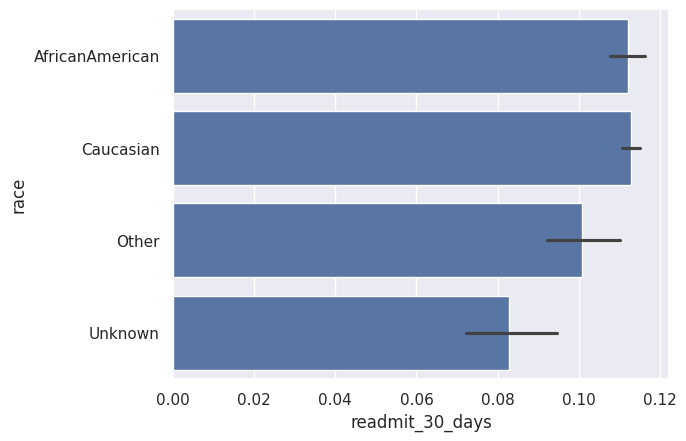

In [24]:
sns.barplot(x="readmit_30_days", y="race", data=df, errorbar=('ci', 95));

We see the rate of *30-day readmission* is similar for the *AfricanAmerican* and *Caucasian* groups, but appears smaller for *Other* and smallest for *Unknown* (this is consistent with an overall lower rate of hospital visits in the prior year). The smaller sample size of the *Other* and *Unknown* groups mean that there is more uncertainty around the estimate for these two groups.

## Proxies for sensitive features



Next, we'll look into identifying features that are highly predictive of the sensitive feature race; these features are known as proxies.

In this tutorial, we primarily address fairness by examining the impact of the machine-learning model across different groups. However, other fairness perspectives focus on how the model may utilize information from sensitive features and which uses of this information are justifiable—often analyzed through causal reasoning. Additionally, certain uses of sensitive features (or their proxies) may be restricted by law in some settings.

Understanding proxies is also important because they can help explain observed impact differences among groups, even if the model doesn’t explicitly use the sensitive feature.

In this section, we’ll touch on identifying such proxies, without delving into the legal or causal aspects.


In the United States, Medicare and Medicaid are federal-state programs designed to help eligible individuals cover healthcare costs. Medicare is generally available for people over 65 and younger individuals with serious health conditions, while Medicaid assists low-income individuals under 65 whose adjusted gross income is below the Federal Poverty Line.

Let’s start by examining how Medicaid as a payment source relates to our demographic features. Since Medicaid is aimed at low-income individuals and socioeconomic status often correlates with race in the United States, we can expect a relationship between race and payment with Medicaid.

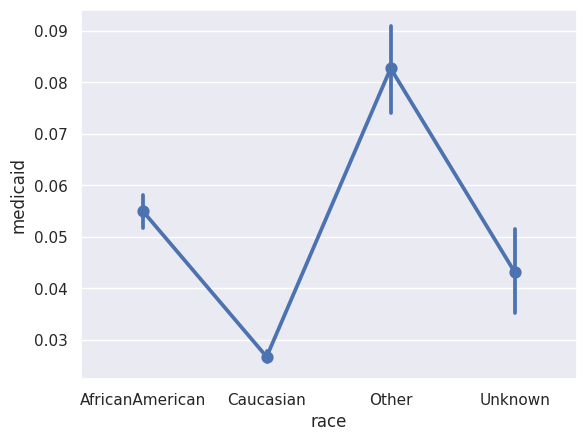

In [25]:
sns.pointplot(y="medicaid", x="race", data=df);

Our analysis confirms that there is indeed a relationship between paying with Medicaid and patient race. Caucasian patients are less likely to pay with Medicaid compared to other groups. Since Medicaid often serves as a proxy for socioeconomic status, these patterns align with known socioeconomic disparities across racial groups in the United States, reflecting broader patterns of wealth distribution and access to resources.

## YOUR TASK: Plot the relationship between race and Medicare and add a brief comment describing what you observe.

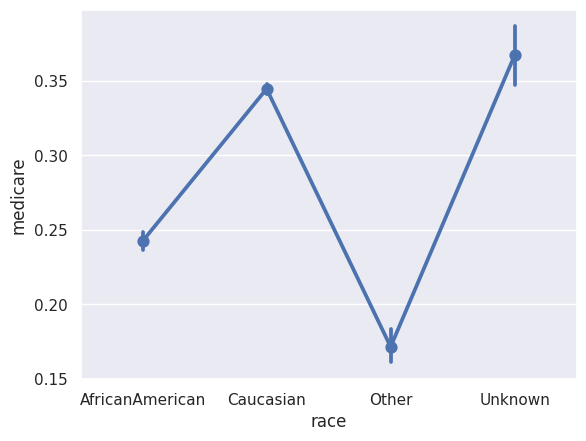

In [26]:
sns.pointplot(y="medicare", x="race", data=df);


The relationship between race and Medicare usage indicates that patients identified as Caucasian have a higher likelihood of using Medicare compared to other racial groups. This pattern aligns with known demographic trends in the U.S., where Medicare predominantly covers older adults, among whom a larger proportion are Caucasian.

<a name="datasheets"></a>
## Datasheets for datasets

The _datasheets_ practice was proposed by [Gebru et al. (2018)](https://arxiv.org/abs/1803.09010). A datasheet of a given dataset documents the motivation behind the dataset creation, the dataset composition, collection process, recommended uses and many other characteristics. In the words of Gebru et al., the goal is to
> facilitate better communication between dataset creators
> and dataset consumers, and encourage the machine learning
> community to prioritize transparency and accountability.

In this section, we show how to fill in some of the sections of the datasheet for the dataset that we are using. The information is obtained directly from [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/).

### Example sections of a datasheet [OPTIONAL SECTION]

**For what purpose was the dataset created?** *Was there a specific task in mind? Was there a specific gap that needed to be filled?*

In the words of the dataset authors:
> [...] the management of hyperglycemia in the hospitalized patient has a significant bearing on outcome, in terms of both morbidity and mortality. This recognition has led to the development of formalized protocols in the intensive care unit (ICU) setting [...] However, the same cannot be said for most non-ICU inpatient admissions. [...] there are few national assessments of diabetes care in the hospitalized patient which could serve as a baseline for change [in the non-ICU protocols]. The present analysis of a large clinical database was undertaken to examine historical patterns of diabetes care in patients with diabetes admitted to a US hospital and to inform future directions which might lead to improvements in patient safety.

**Who created the dataset (e.g., which team) and on behalf of which entity?**

The dataset was created by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/): a team of researchers from a variety of disciplines, ranging from computer science to public health, from three institutions (Virginia Commonwealth University, University of Cordoba, and Polish Academy of Sciences).

#### **Composition**

**What do the instances that comprise the dataset represent?**



Each instance in this dataset represents a hospital admission for diabetic patient (diabetes was entered as a possible diagnosis for the patient) whose hospital stay lasted between one to fourteen days.

**Is any information missing from individual instances?**

The features `Payer Code` and `Medical Specialty` have 40,255 and 49,947 missing values, respectively. For `Payer Code`, these missing values are reflected in the category *Unknown*. For `Medical Specialty`, these missing values are reflecting in the category *Missing*.

For our demographic features, we are missing the `Gender` information for three patients in the dataset. These three records were dropped from our final dataset. Regarding `Race`, the 2,271 missing values were recoded into the `Unknown` race category.



**Does the dataset identify any subpopulations (e.g., by age, gender)?**

Patients are identified by gender, age group, and race.

For gender, patients are identified as Male, Female, or Unknown. There were only three instances where the patient gender is *Unknown*, so these records were removed from our dataset.

Gender | Count| Percentage
------ | ------|----------
Male      | 47055     | 46.2%
Female     |  54708     | 53.7%  



For age group, patients are binned into three age buckets: *30 years or younger*, *30-60 years*, *Older than 60 years*.

Age Group |Count| Percentage
------ | ------|----------
30 years or younger      | 2509     | 2.4%
30-60 years       | 30716   | 30.2%
Older than 60 years      |   68538    | 67.4%  


For race, patients are identified as *AfricanAmerican*, *Caucasian*, and *Other*. For individuals whose race information was not collected during hospital admission, their race is listed as *Unknown*.

Race | Count| Percentage
------ | ------|----------
Caucasian      | 76099     | 74.8%
AfricanAmerican     |  19210     | 18.9%  
Other        |     4183         |  4.1%
Unknown        |    2271          | 2.2%

#### **Preprocessing**

**Was any preprocessing/cleaning/labeling of the data done?**

For the `race` feature, the categories of *Asian* and *Hispanic* and *Other* were merged into the *Other* category. The `age` feature was bucketed into 30-year intervals (*30 years and below*, *30 to 60 years*, and *Over 60 years*). The `discharge_disposition_id` was binarized into a boolean outcome on whether an patient was discharged to home.

The full preprocessing code is provided in the file `preprocess.py` of the tutorial [GitHub repository](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/).




#### **Uses**



**Has the dataset been used for any tasks already?**

This dataset has been used by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/) to model the relationship between patient readmission and HbA1c measurement during admission, based on primary medical diagnosis.

The dataset is publicly available through the UCI Machine Learning Repository and, as of May 2021, has received over 350,000 views.

# Training the initial model

To choose a model for predicting 30-day readmissions, it’s essential to consider the trade-offs between interpretability and model expressiveness. Here’s a breakdown of the options:

* Interpretability: This factor is critical for fairness, as interpretable models enable stakeholders to understand and scrutinize predictions. Interpretability matters because:

 * Stakeholders might identify fairness issues that data scientists could overlook.
 * A transparent model gives people affected by its predictions a chance for recourse.
 * Domain experts can perform a "face validity" check to validate that the model aligns with their intuitive understanding.
 * With interpretability in mind, simpler models like logistic regression are often preferable, as they offer direct insight into how predictions are made. Decision trees and certain implementations of random forests also allow for interpretability but at a moderate complexity increase.

* Model Expressiveness: This aspect considers how well the model can distinguish between positive and negative outcomes, particularly across diverse groups. More expressive models, like random forests or deep neural networks, may capture complex patterns that logistic regression cannot. However, a more expressive model might also lead to overfitting on smaller datasets or disparities in performance across groups.

Additional considerations:

Training time is a practical factor, impacting how quickly we can iterate on and refine the model.
Familiarity with a model can also ease fine-tuning and troubleshooting.
Carbon footprint is increasingly important, especially for larger models like neural networks, as these consume significant computational resources and have environmental impacts.<br>

Recommendation: Given these considerations, a logistic regression or random forest might be a good starting point, balancing interpretability with reasonable expressiveness.

### Decision point: Model type

We will use a logistic regression model. Our reasoning:

* **Interpretability**. Logistic models over a small number of variables (as used here) are highly interpretable in the sense that stakeholders can simulate them easily.

* **Model expressiveness**. Logistic regression predictions are described by a linear weighting of the feature values. The concern might be that this is too simple. The previous work by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/), which also used a logistic model to predict readmission rates concluded that a slightly more expressive model might be useful (their analysis uncovered 8 pairwise interactions that were significant, see their Table 5).

## Prepare training and test datasets

As we mentioned in the task definition, our target variable is **readmission within 30 days**, and our sensitive feature for the purposes of fairness assessment is **race**.


In [27]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]
# If multiple sensitive features are chosen, the rest of the script considers intersectional groups.

In [28]:
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

We next drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [29]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

In [30]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_>8,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,False,False,False,False,False,...,False,False,False,True,False,False,False,True,True,False
1,3,59,0,18,9,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
2,2,11,5,13,6,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,True
3,2,44,1,16,7,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,True
4,1,51,0,8,5,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


We split our data into a training and test portion. The test portion will be used to evaluate our performance metric (i.e., balanced accuracy), but also for fairness assessment. The split is half/half for training and test to ensure that we have sufficient sample sizes for fairness assessment.

In [31]:
random_seed = 123
np.random.seed(random_seed)

In [32]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Our performance metric is **balanced accuracy**, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples.


Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [33]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [34]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

## Save descriptive statistics of training and test data

We next evaluate the descriptive statistics of the training dataset. These can be provided as part of _model cards_ to document our training.

Text(0.5, 1.0, 'Sensitive Attributes for Training Dataset')

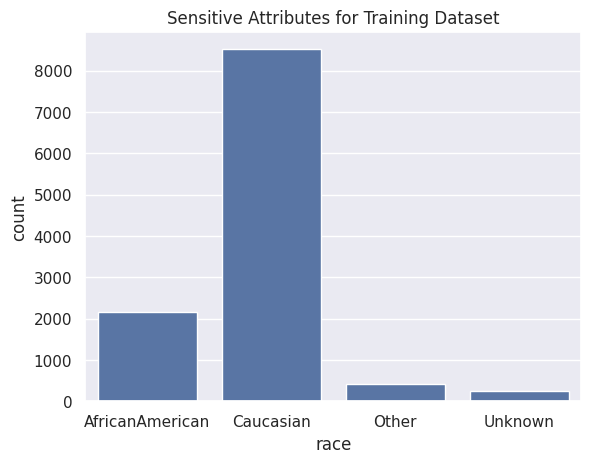

In [35]:
sns.countplot(x="race", data=A_train_bal)
plt.title("Sensitive Attributes for Training Dataset")

Text(0.5, 1.0, 'Target Label Histogram for Training Dataset')

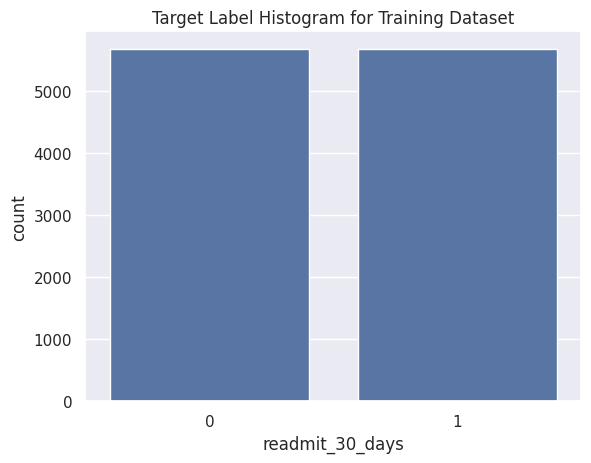

In [36]:
sns.countplot(x=Y_train_bal)
plt.title("Target Label Histogram for Training Dataset")

Text(0.5, 1.0, 'Sensitive Attributes for Testing Dataset')

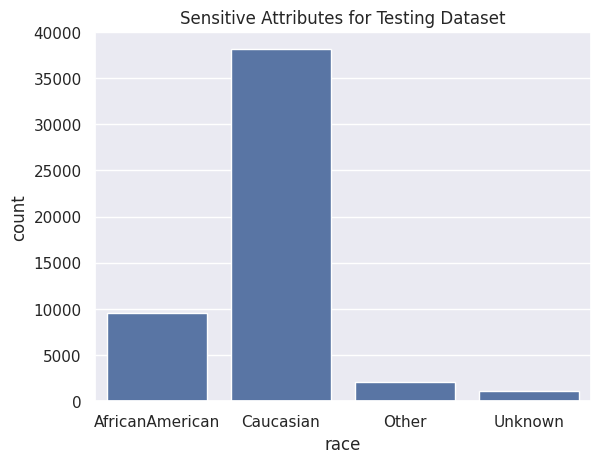

In [37]:
sns.countplot(x="race", data=A_test)
plt.title("Sensitive Attributes for Testing Dataset")

Text(0.5, 1.0, 'Target Label Histogram for Test Dataset')

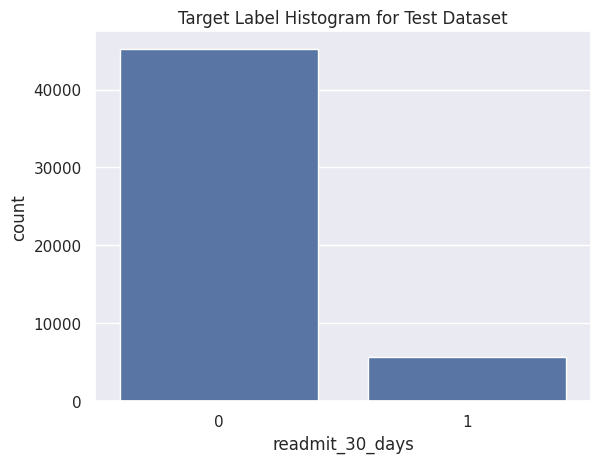

In [38]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")

## Train the model

We train a logistic regression model and save its predictions on test data for analysis.

In [39]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [40]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [41]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

In [42]:
Y_pred

array([0, 1, 0, ..., 1, 0, 0])

Check model performance on test data.

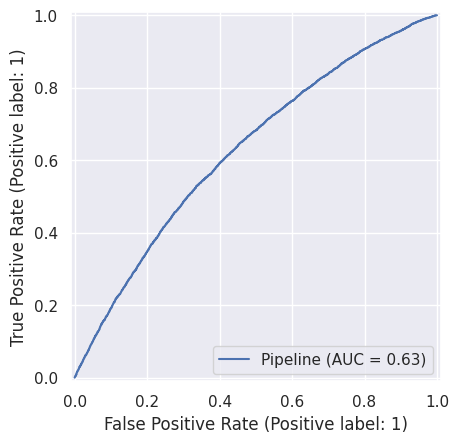

In [43]:
# Plot ROC curve of probabilistic predictions
RocCurveDisplay.from_estimator(unmitigated_pipeline, X_test, Y_test);

In [44]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5936067117421118

As we see, the performance of the model is well above the performance of a coin flip (whose performance would be 0.5 in both cases), albeit it is quite far from a perfect classifier (whose performance would be 1.0 in both cases).


# **Fairness assessment**

## Measuring fairness-related harms





The goal of fairness assessment is to answer the question: *Which groups of people may be disproportionately negatively impacted by an AI system and in what ways?*

The steps of the assesment are as follows:
1. Identify harms
2. Identify the groups that might be harmed
3. Quantify harms
4. Compare quantified harms across the groups

We next examine these four steps in more detail.

### 1. Identify harms

For example, in a system for screening job applications, qualified candidates that are automatically rejected experience an allocation harm. In a speech-to-text transcription system, high error rates constitute harm in the quality of service.

**In the health care scenario**, the patients that would benefit from a care management program, but are not recommended for it experience a harm. In the context of the classification scenario these are **FALSE NEGATIVES**.

### 2. Identify the groups that might be harmed

In most applications, we consider demographic groups including historically marginalized groups (e.g., based on gender, race, ethnicity).

It is also important to consider group intersections, for example, in addition to considering groups according to gender and groups according to race, it is also important to consider their intersections (e.g., Black women, Latinx nonbinary people, etc.).

**In the health care scenario**, based on the previous work, we focus on groups defined by **race**.

### 3. Quantify harms

Define metrics that quantify harms or benefits:

* In job screening scenario, we need to quantify the number of candidates that are classified as "negative" (not recommended for the job), but whose true label is "positive" (they are qualified). One possible metric is the **false negative rate**: fraction of qualified candidates that are screened out.

* In speech-to-text scenario, the harm could be measured by **word error rate**, number of mistakes in a transcript divided by the overall number of words.

* **In the health care scenario**, we could consider two metrics for quantifying harms / benefits:
  * **false negative rate**: fraction of patients that are readmitted within 30 days, but that are not recommended for the care management program; this quantifies harm
  * **selection rate**: overall fraction of patients that are recommended for the care management program (regardless of whether they are readmittted with 30 days or no); this quantifies benefit; here the assumption is that all patients benefit similarly from the extra care.

There are several reasons for including selection rate in addition to false negative rate. We would like to monitor how the benefits are allocated, focusing on groups that might be disadvantaged. Another reason is to get extra robustness in our assessement, because our measure (i.e., readmission within 30 days) is only an imperfect measure of our construct (who is most likely to benefit from the care management program). The auxiliary metrics, like selection rate, may alert us to large disparities in how the benefit is allocated, and allow us to catch issues that we might have missed.


### 4. Compare quantified harms across the groups

The workhorse of fairness assessment are _disaggregated metrics_, which are **metrics evaluated on slices of data**. For example, to measure harms due to errors, we would begin by evaluating the errors on each slice of the data that corresponds to a group we identified in Step 2.
If some of the groups are seeing much larger errors than other groups, we would flag this as a fairness harm.

To summarize the disparities in errors (or other metrics), we may want to report quantities such as the **difference** or **ratio** of the metric values between the best and the worst slice. In settings where the goal is to guarantee certain minimum quality of service (such as speech recognition), it is also meaningful to report the **worst performance** across all considered groups.



For example, when comparing false negative rate across groups defined by race, we may summarize our findings with a table like the following:

| | false negative rate<br>(FNR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FNR_|0.67|

## Fairness assessment with `MetricFrame`

Fairlearn provides the data structure called `MetricFrame` to enable evaluation of disaggregated metrics. We will show how to use a `MetricFrame` object to assess the trained `LogisticRegression` classifier for potential fairness-related harms.



In [45]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

,false_negative_rate
race,
AfricanAmerican,0.409
Caucasian,0.439
Other,0.516
Unknown,0.628


In [46]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.219
ratio: 0.651
max across groups: 0.628


In [47]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.413,0.409,0.600
Caucasian,0.397,0.439,0.593
Other,0.343,0.516,0.579
Unknown,0.238,0.628,0.573


In [48]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

,0
selection_rate,0.174
false_negative_rate,0.219
balanced_accuracy,0.027


## YOUR TASK: Generate a similar table for "ratio" instead of "difference"

In [69]:
# Use ratio:
metricframe_unmitigated.ratio()


,0
selection_rate,0.578
false_negative_rate,0.651
balanced_accuracy,0.955


In [50]:
# You can view all of them in the same table:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.174,0.219,0.027
ratio,0.578,0.651,0.955
group_min,0.238,0.409,0.573
group_max,0.413,0.628,0.600


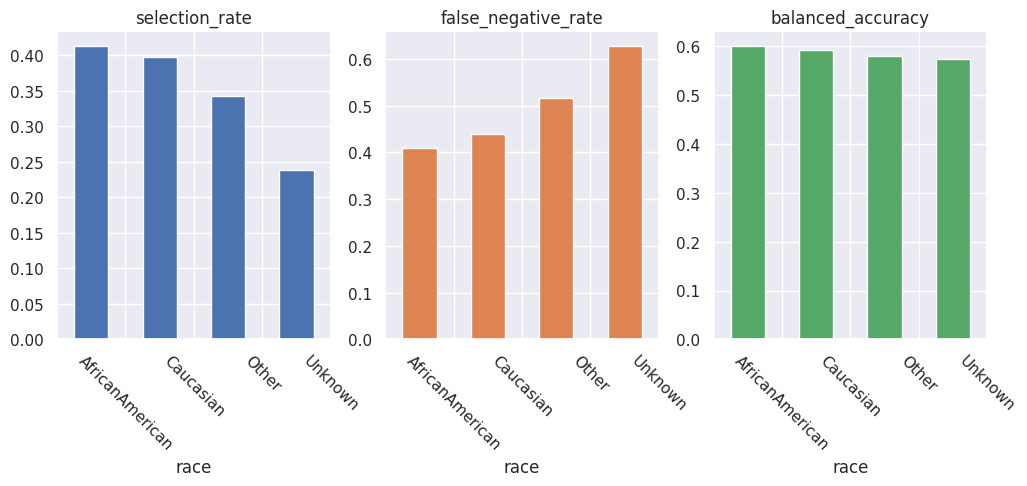

In [51]:
# You can also easily plot all the metrics

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

According to the above bar chart, it seems that the group *Unknown* is selected for the care management program less often than other groups as reflected by the selection rate. This group also experiences the largest false negative rate, so a larger fraction of group members that are likely to benefit from the care management program are not selected. Finally, the balanced accuracy on this group is also the lowest.



We observe disparity, even though we did not include race in our model. There's a variety of reasons why such disparities may occur. It could be due to representational issues (i.e., not enough instances per group), or because the feature distribution itself differs across groups (i.e., different relationship between features and target variable, obvious example would be people with darker skin in facial recognition systems, but can be much more subtle). Real-world applications often exhibit both kinds of issues at the same time.



---


# **Mitigating fairness-related harms in ML models**

We have found that the logistic regression predictor leads to a large difference in false negative rates between the groups. We next look at **algorithmic mitigation strategies** of this fairness issue (and similar ones).

*Note that while we currently focus on the training stage of the AI lifecycle, mitigation should not be limited to this stage. In fact, we have already discussed mitigation strategies at the task definition stage (e.g., checking for construct validity) and data collection stage (e.g., collecting more data).*

Within the model training stage, mitigation may occur at different steps relative to model training:

* **Preprocessing**: A mitigation algorithm is applied to transform the input data to the training algorithm; for example, some strategies seek to remove the dependence between the input features and sensitive features.

* **At training time**: The model is trained by an (optimization) algorithm that seeks to satisfy fairness constraints.

* **Postprocessing**: The output of a trained model is transformed to mitigate fairness issues; for example, the predicted probability of readmission is thresholded according to a group-specific threshold.

We will explore a postprocessing approach which is in fact a **meta-algorithm** in the sense that it acts as a wrapper around *any* standard (fairness-unaware) machine learning algorithms. This makes it quite versatile in practice.


## Postprocessing with `ThresholdOptimizer`

**Postprocessing** techniques are a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.


Here we use the `ThresholdOptimizer` algorithm from Fairlearn, which follows the approach of [Hardt, Price, and Srebro (2016)](https://arxiv.org/abs/1610.02413).

`ThresholdOptimizer` takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate threshold for each group in order to optimize some specified objective metric (such as **balanced accuracy**) subject to specified fairness constraints (such as **false negative rate parity**). Thus, the resulting classifier is just a suitably thresholded version of the underlying machine learning model.

The constraint **false negative rate parity** requires that all the groups have equal values of false negative rate.



To instatiate our `ThresholdOptimizer`, we need:

*   An existing `estimator` that we wish to threshold.
*   The fairness `constraints` we want to satisfy.
*   The `objective` metric we want to maximize.



In [52]:
# Instantite ThresholdOptimizer with the logistic regression estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_negative_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In order to use the `ThresholdOptimizer`, we need access to the sensitive features **both during training time and once it's deployed**.

In [53]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [54]:
# Record and evaluate the output of the trained ThresholdOptimizer on test data

Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

## How does the ThresholdOptimizer actually work?

The threshold optimizer alters the predictions made by the pretrained logistic regression model but doesn’t change the model itself. Instead, it modifies how the pretrained model’s predictions are “interpreted” for the different groups in the race variable by using custom cut-off points (called “thresholds”) for each group. In the part where we reviewed the predictions of the logistic regression model in the “Train the model” section using commands like printing Y_pred and Y_pred_proba, we established that Y_pred_proba works by translating a probability below 0.5 for a given patient into a value of 0 in Y_pred, which is binary (1 if a patient is predicted to be re-admitted within 30 days, and 0 otherwise); conversely, if Y_pred_proba for a patient is above 0.5, it becomes a “1” in Y_pred. This default 0.5 cut-off point is precisely what the threshold optimizer may try to customize for different racial groups based on our constraint — in this case, false negative rate parity.

The threshold optimizer, based on the grouping of patients by the sensitive feature (in our case, “race”), may slightly lower the 0.5 threshold for people in the “Unknown” category. So, for instance, a patient in that category who receives a prediction probability of 0.45 may still be “interpreted” as a 1 in Y_pred; i.e., the threshold for this particular group will be adjusted so that people in this group need a lower probability score to get a positive prediction, which in turn mitigates the false negative rate for that group. The optimizer needs access to the sensitive feature information during training to know how many different thresholds it may need to set. In our case, we have four distinct race “buckets,” so there can be four slightly different thresholds — one for each category. During testing, it needs the sensitive feature information again to know which threshold to apply to a given patient. For example, if the modified threshold for “Unknown” is 0.45, and that’s the category a patient belongs to, then that will be the cut-off point for deciding whether they should be counted as 1 or 0 with respect to the 30-day readmission outcome variable.

According to this logic, since the sensitive feature is only used to determine group membership and ensure the proper threshold is applied, its use may be deemed “permissible” because it’s not part of the underlying training process and doesn’t impact the core structure of the model.

We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

In [55]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                selection_rate false_negative_rate balanced_accuracy   
race                                                                   
AfricanAmerican          0.413               0.409             0.600   
Caucasian                0.397               0.439             0.593   
Other                    0.343               0.516             0.579   
Unknown                  0.238               0.628             0.573   

                ThresholdOptimizer                                        
                    selection_rate false_negative_rate balanced_accuracy  
race                                                                      
AfricanAmerican              0.388               0.447             0.593  
Caucasian                    0.388               0.446             0.593  
Other                        0.338               0.533             0.572  
Unknown                      0.447               0.457             0.552

We next zoom in on differences between the largest and the smallest metric values:

In [56]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated: difference,0.174,0.219,0.027
ThresholdOptimizer: difference,0.110,0.087,0.041


As we see, `ThresholdOptimizer` was able to substantiallydecrease the difference between the values of false negative rate.

Finally, we plot the disagregated statistics:

array([[<Axes: title={'center': 'selection_rate'}, xlabel='race'>,
        <Axes: title={'center': 'false_negative_rate'}, xlabel='race'>,
        <Axes: title={'center': 'balanced_accuracy'}, xlabel='race'>]],
      dtype=object)

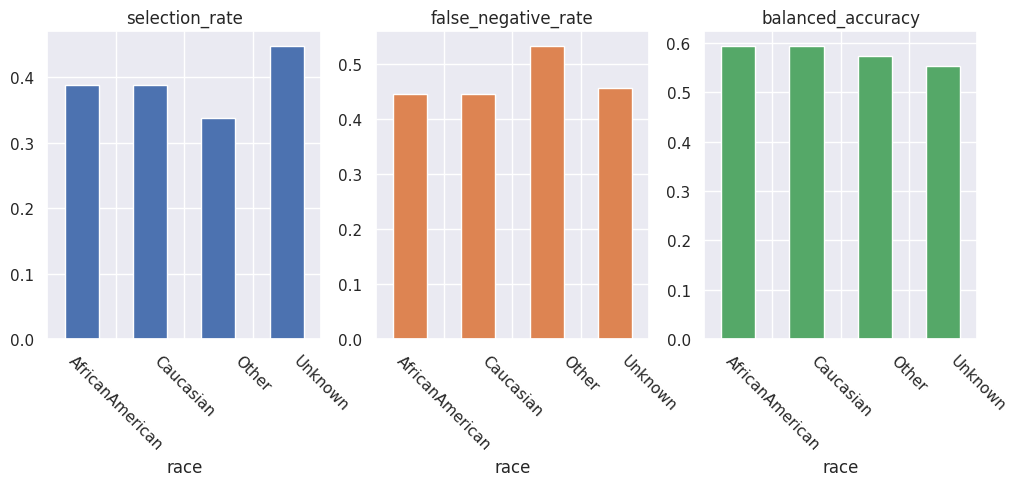

In [57]:
metricframe_postprocess.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4), legend=False, rot=-45, position=1.5)

#### Model performance - by group

In [58]:
def plot_technique_comparison(mf_dict, metric):
  """
  Plots a specified metric for a given dictionary of MetricFrames.
  """
  mf_dict = {k:v.by_group[metric] for (k,v) in mf_dict.items()}
  comparison_df = pd.DataFrame.from_dict(mf_dict)
  comparison_df.plot.bar(figsize=(12, 6), legend=False)
  plt.title(metric)
  plt.xticks(rotation=0, ha='center');
  plt.legend(bbox_to_anchor=(1.01,1), loc='upper left')

In [59]:
test_dict = {
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
}

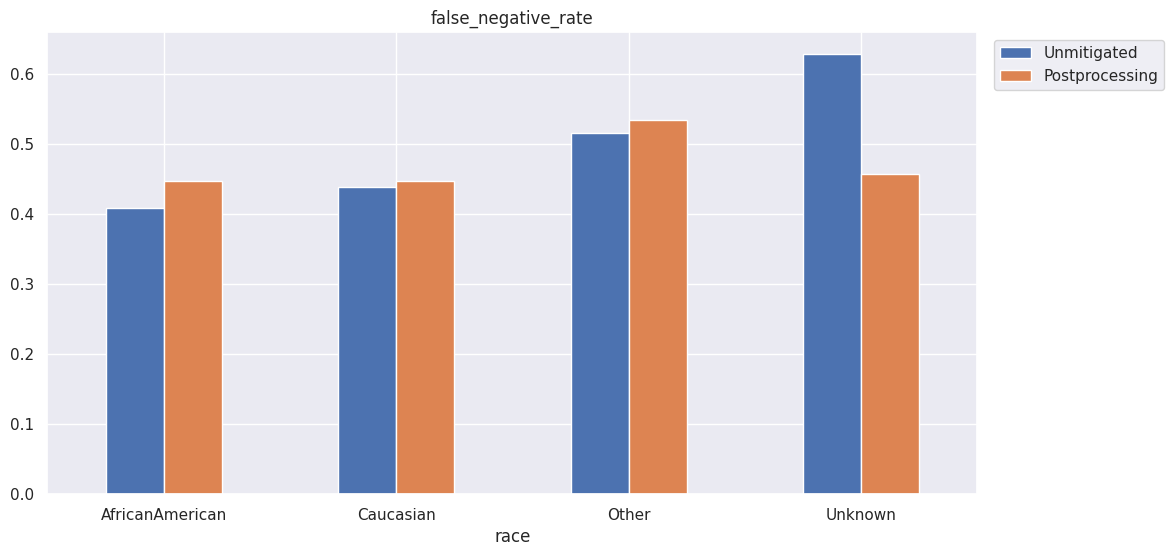

In [60]:
plot_technique_comparison(test_dict, "false_negative_rate")

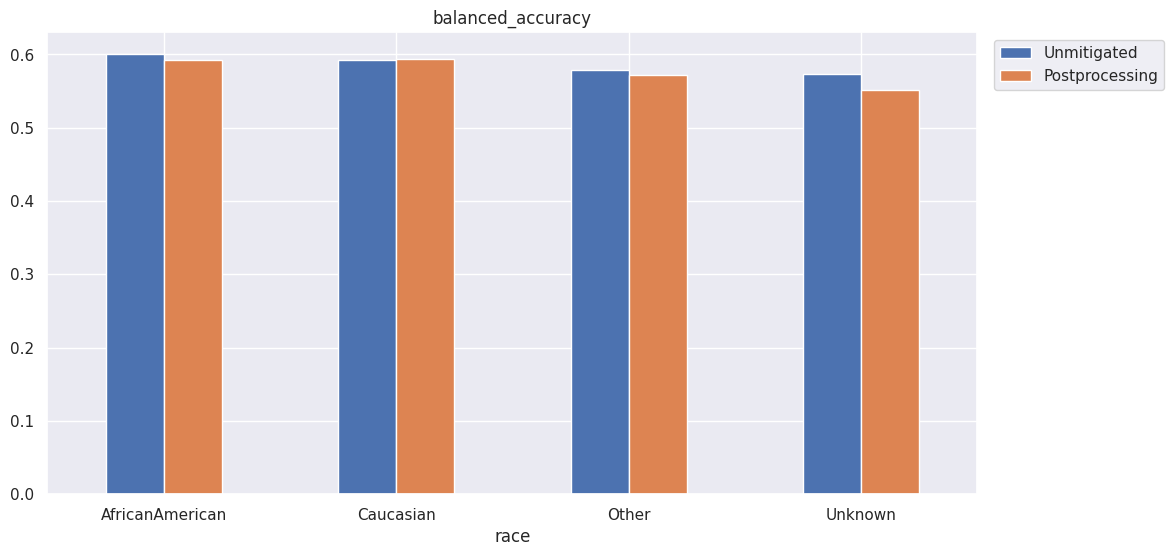

In [61]:
plot_technique_comparison(test_dict, "balanced_accuracy")

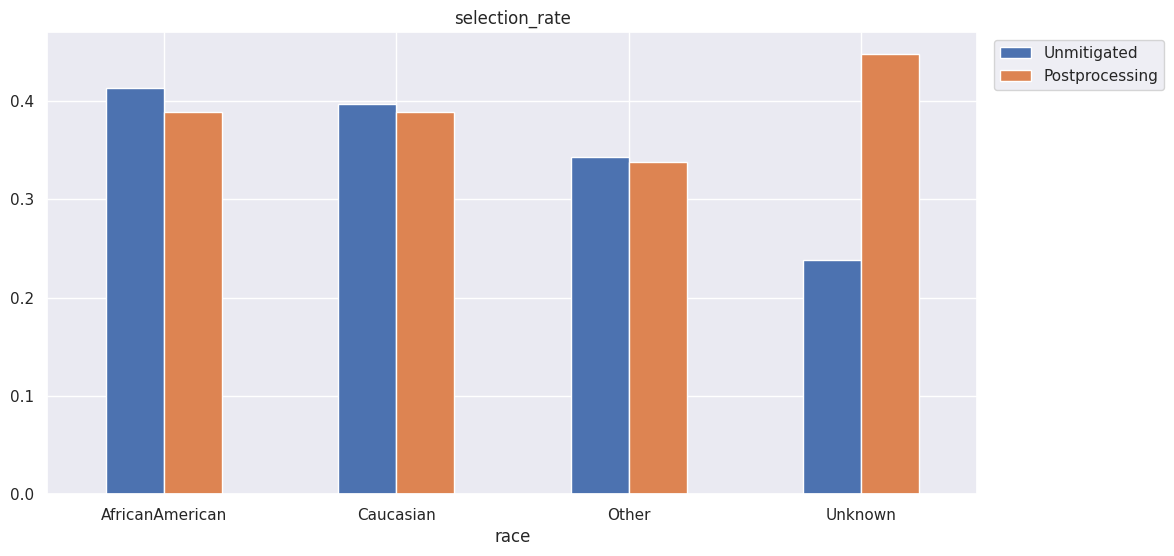

In [62]:
plot_technique_comparison(test_dict, "selection_rate")



#### Model performance - overall

In [63]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall
})

In [64]:
overall_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.394,0.439,0.594
Postprocessing,0.387,0.450,0.591


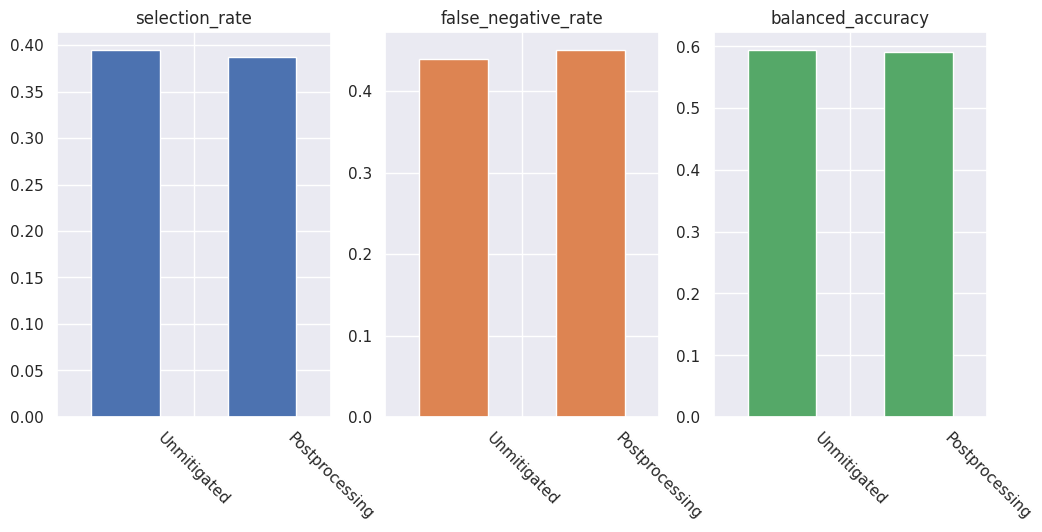

In [65]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

In [66]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference()
}
)

In [67]:
difference_df.T

,selection_rate,false_negative_rate,balanced_accuracy
Unmitigated,0.174,0.219,0.027
Postprocessing,0.110,0.087,0.041


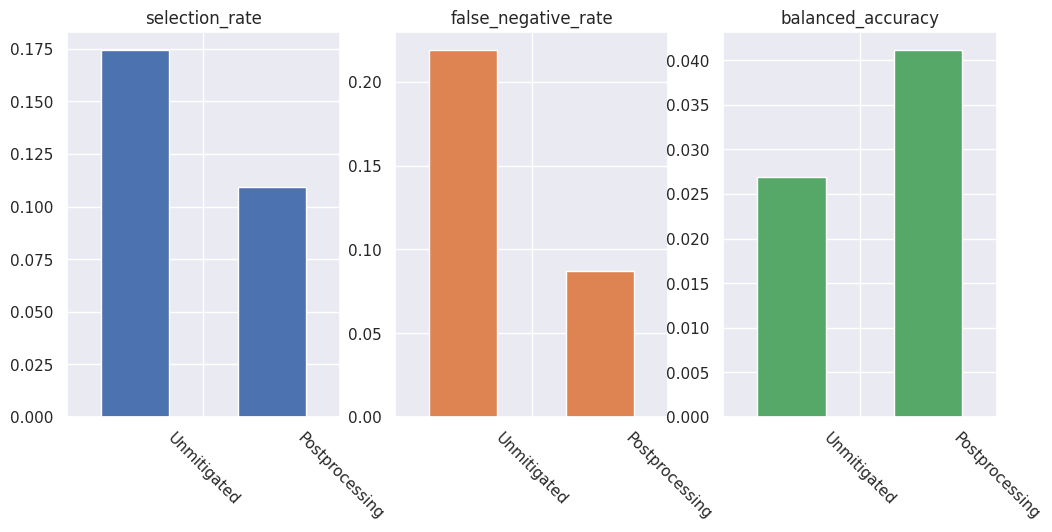

In [68]:
difference_df.T.plot.bar(subplots=True, layout= [1,3], figsize=(12, 5), legend=False, rot=-45, position=1.5);

### Access to sensitive features





*   The `ThresholdOptimizer` model requires access to the sensitive features during BOTH training time and once deployed. If you do not have access to the sensitive features once the model is deployed, you will not be able to use the `ThresholdOptimizer`.




# Discussion and conclusion

In this tutorial, we walked through a healthcare scenario across each stage of the AI lifecycle, stopping short of model deployment. We explored how fairness-related harms can emerge at each stage - from defining the task and collecting data to training and evaluating the model. Along the way, we used tools and practices like datasheets for datasets, Fairlearn, and model cards to address these concerns.

After deployment, it’s essential to keep monitoring key metrics to detect performance variations or potential fairness issues. As more is learned about how the model is used, you may need to refine fairness metrics, update the model, incorporate new sensitive features, revisit the task definition, or gather additional data.

While we used a range of software tools, it’s important to remember that fairness is a sociotechnical challenge. Technical fixes alone aren’t enough; they need to be supported by broader processes, practices, and often, regulatory and organizational changes.

If you’re interested in learning more about fairness in AI or contributing to Fairlearn, you're invited to join the community, where contributors bring diverse expertise and perspectives to this work.

Further resources can also be found [on the FAIRLEARN website](https://fairlearn.org/main/user_guide/further_resources.html).